<a href="https://colab.research.google.com/github/sabina14/OD_Detectron2/blob/main/Custom_training_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Detectron2 and dependencies

In [1]:
# install dependeoncies
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__,torch.cuda.is_available())

1.10.0+cu111 True


In [3]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith('1.10')
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html

#exit(0) # After installation, you need to "restart runtime" in Colab. This line can also restar

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html


Basic Setup

In [3]:
#set up detectron2 logger

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

#import common libraries

import numpy as np
import os,json,cv2,random
#from google.colab.patches import cv2__imshow

#import detectron2 utilities

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:
# from google.colab import drive
# drive.mount('content/drive')

In [6]:
!pwd

/content


In [7]:
cd "/content/drive/MyDrive/Object_detection/Detectron2_OD"

/content/drive/MyDrive/Object_detection/Detectron2_OD


In [8]:
!unzip data_detectron2.zip

Archive:  data_detectron2.zip
   creating: data_detectron2/
  inflating: data_detectron2/output.json  
   creating: data_detectron2/train/
  inflating: data_detectron2/train/cam_image1.jpg  
  inflating: data_detectron2/train/cam_image10.jpg  
  inflating: data_detectron2/train/cam_image11.jpg  
  inflating: data_detectron2/train/cam_image12.jpg  
  inflating: data_detectron2/train/cam_image13.jpg  
  inflating: data_detectron2/train/cam_image14.jpg  
  inflating: data_detectron2/train/cam_image15.jpg  
  inflating: data_detectron2/train/cam_image16.jpg  
  inflating: data_detectron2/train/cam_image17.jpg  
  inflating: data_detectron2/train/cam_image18.jpg  
  inflating: data_detectron2/train/cam_image19.jpg  
  inflating: data_detectron2/train/cam_image20.jpg  
  inflating: data_detectron2/train/cam_image21.jpg  
  inflating: data_detectron2/train/cam_image22.jpg  
  inflating: data_detectron2/train/cam_image23.jpg  
  inflating: data_detectron2/train/cam_image24.jpg  
  inflating: d

In [9]:
%cd data_detectron2

/content/drive/MyDrive/Object_detection/Detectron2_OD/data_detectron2


Register the instances

In [12]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("Carddata",{},"./output.json","./train")

In [14]:
sample_metadata=MetadataCatalog.get("Carddata")
dataset_dicts= DatasetCatalog.get("Carddata")

WARNING [02/23 06:47:34 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/23 06:47:34 d2.data.datasets.coco]: Loaded 290 images in COCO format from ./output.json


Visulaize the data

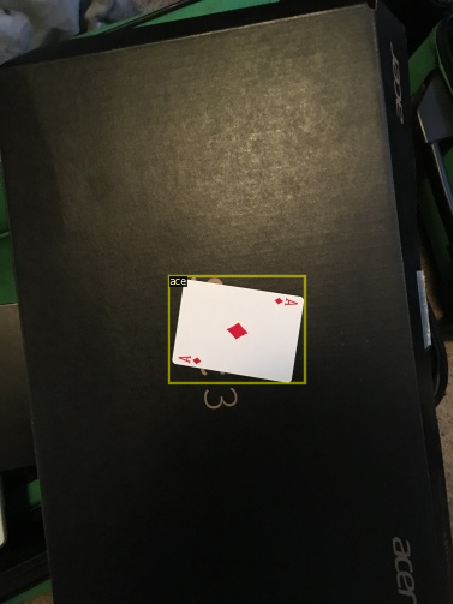

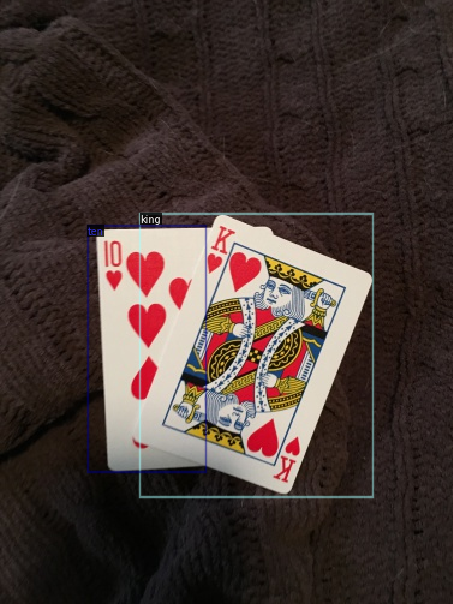

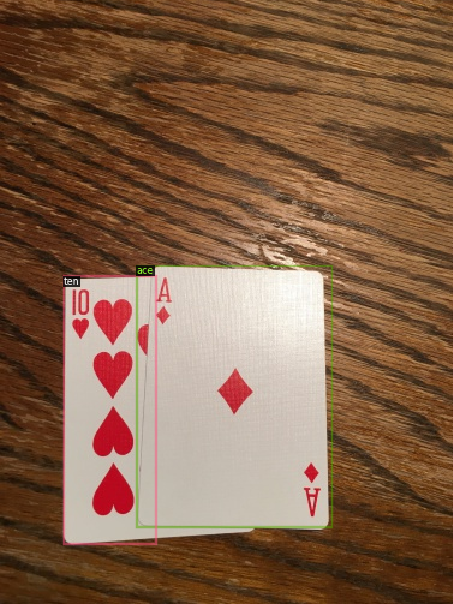

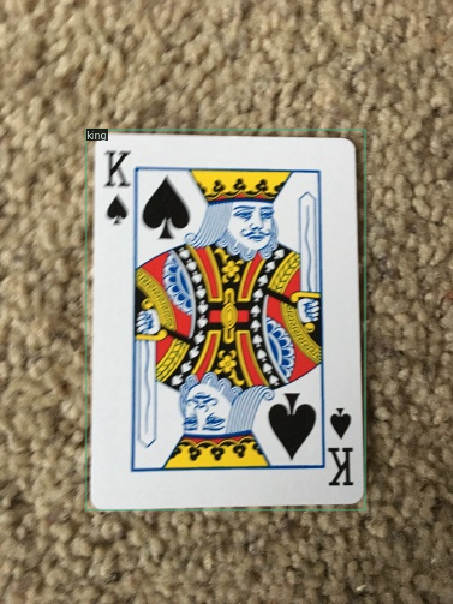

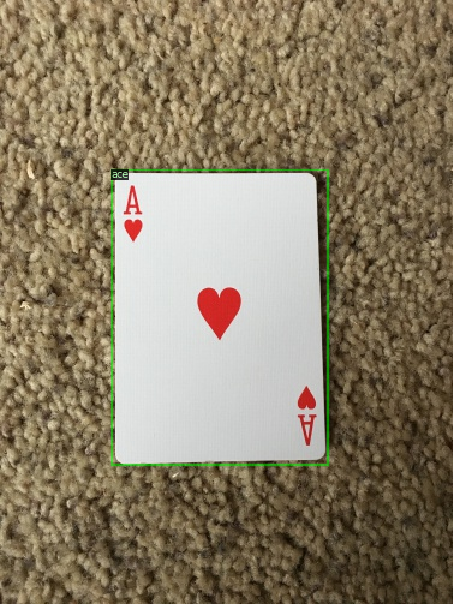

In [17]:
import random
from google.colab.patches import cv2_imshow

for d in random.sample(dataset_dicts,5):
  img=cv2.imread(d["file_name"])
  visualizer= Visualizer(img[:,:,::-1], metadata=sample_metadata,scale=1.2)
  vis=visualizer.draw_dataset_dict(d)
  cv2_imshow(vis.get_image()[:,:,::-1])

Train the model

In [21]:
from detectron2.engine import DefaultTrainer

cfg=get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN= ("Carddata",)
cfg.DATASETS.TEST=()
cfg.DATALOADER.NUM_WORKERS= 2
cfg.MODEL.WEIGHTS=model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH=2
cfg.SOLVER.BASE_LR=0.0025 #pick a good lr
cfg.SOLVER.MAX_ITER=500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE=128 #(default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES=6 # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR,exist_ok=True)
trainer=DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()


[02/23 07:11:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:04, 35.0MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_p

[02/23 07:11:27 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/23 07:11:35 d2.utils.events]:  eta: 0:02:59  iter: 19  total_loss: 2.552  loss_cls: 1.831  loss_box_reg: 0.7313  loss_rpn_cls: 0.003153  loss_rpn_loc: 0.004791  time: 0.3761  data_time: 0.0175  lr: 9.7405e-05  max_mem: 2800M
[02/23 07:11:43 d2.utils.events]:  eta: 0:02:47  iter: 39  total_loss: 1.536  loss_cls: 0.7282  loss_box_reg: 0.737  loss_rpn_cls: 0.003882  loss_rpn_loc: 0.005239  time: 0.3771  data_time: 0.0072  lr: 0.00019731  max_mem: 2800M
[02/23 07:11:51 d2.utils.events]:  eta: 0:02:46  iter: 59  total_loss: 1.29  loss_cls: 0.5427  loss_box_reg: 0.7351  loss_rpn_cls: 0.001739  loss_rpn_loc: 0.004172  time: 0.3803  data_time: 0.0094  lr: 0.0002972  max_mem: 2800M
[02/23 07:11:58 d2.utils.events]:  eta: 0:02:35  iter: 79  total_loss: 1.361  loss_cls: 0.5688  loss_box_reg: 0.7763  loss_rpn_cls: 0.0004125  loss_rpn_loc: 0.003154  time: 0.3803  data_time: 0.0067  lr: 0.00039711  max_mem: 2800M
[02/23 07:12:06 d2.utils.events]:  eta: 0:02:29  iter: 99  total_loss: 1.216  loss_

Predict 

In [22]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("Carddata", )
predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


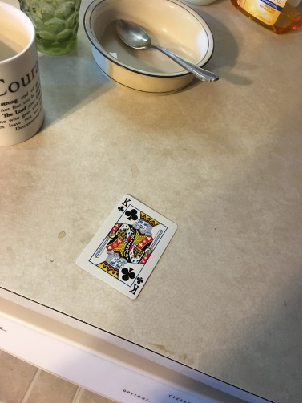

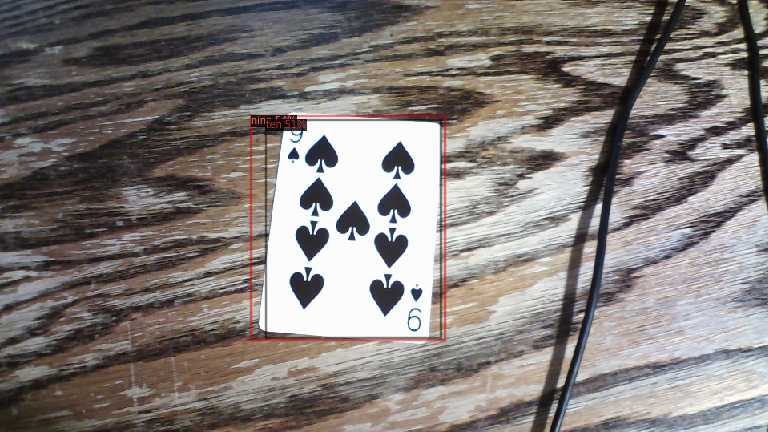

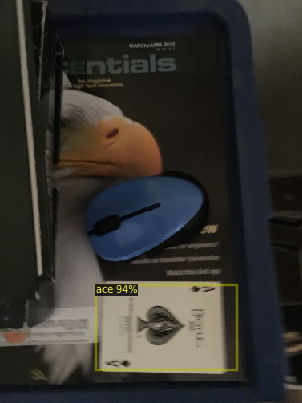

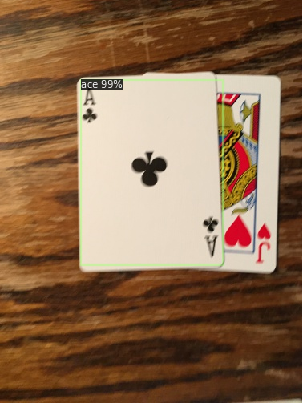

In [24]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 4):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

Get custom config file

In [25]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()